# Université Paul Sabatier

EMIND1G1 - Fondements de la recherche d'information

**TP 2**

Enseignant : José G. Moreno

2020

TP 2. Méthodes de pondération sur Terrier

Les moteurs de recherche utilisent de méthodes de pondération pour donner plus ou moins d'importance à chaque terme. Parmi ces méthodes, nous trouvons BM25 et TF-IDF. Pour utiliser la méthode BM25 sur Terrier, il suffit de donner une valeur au paramètre ``` wmodel ``` au moment d'appeler le ``` BatchRetrieve ``` comme dans l'example :

```
pt.BatchRetrieve(indexref2, wmodel="BM25", metadata=["docno","title","url"]).transform("france")
```

Dans certain cas, il est necessaire de ré-indexer les documents pour permettre à Terrier de prendre en compte les modifications de la méthode de pondération (par example dans le cas où la position est prise en compte).

## 1. Lecture d'un index

Pour ce deuxième TP, on va suposer que l'index existe déjà (voir TP1 si vous voulez le refaire)

In [1]:
# déclaration de la variable JAVA_HOME
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
!export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

In [2]:
#installation de pyterrier avec pip
!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git#egg=python-terrier

  Cloning https://github.com/terrier-org/pyterrier.git to /tmp/pip-install-pxhxk0ca/python-terrier
  Running command git clone -q https://github.com/terrier-org/pyterrier.git /tmp/pip-install-pxhxk0ca/python-terrier
     |████████████████████████████████| 1.1MB 14.9MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.3.0.dev0-cp36-none-any.whl size=54092 sha256=287b9d09311c4de7dc7be74e9ffc1d730e2597a8f60515bbed2abc98ff4a62ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-38cwezs4/wheels/cc/bb/69/836d846a92c787b35ca6478119c0033762ab2b95d866eeb288
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a7aee9f8ff956e4c12b9dcb5dee4e4d9de7989b3b550bb6f4eda0d38d9a0acba
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for pytrec-eval: filename=pytrec_eval-0.5-cp36-cp36m-linux_x86_64.whl size=265280 sha256=0a16cf20a4788b27e52c

In [3]:
#Initialization de JVM
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.3  jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.4  jar not found, downloading to /root/.pyterrier...
Done


Installation de l'index 

In [4]:
#Création du dossier pour le stockage des indexes
import pandas as pd
!rm -rf ./pd_index
pd_indexer = pt.DFIndexer("./pd_index") 

In [5]:
!wget https://dumps.wikimedia.org/simplewiki/20200901/simplewiki-20200901-abstract.xml.gz 

--2020-11-01 11:19:37--  https://dumps.wikimedia.org/simplewiki/20200901/simplewiki-20200901-abstract.xml.gz
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15445414 (15M) [application/octet-stream]
Saving to: ‘simplewiki-20200901-abstract.xml.gz’

simplewiki-20200901 100%[===================>]  14.73M  4.57MB/s    in 3.2s    

2020-11-01 11:19:41 (4.57 MB/s) - ‘simplewiki-20200901-abstract.xml.gz’ saved [15445414/15445414]



In [6]:
!gzip -d simplewiki-20200901-abstract.xml.gz #Décompresse le fichier  

In [7]:
import pandas as pd
import xml.etree.ElementTree as et

def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        for el in df_cols[0:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df 

In [8]:
!head -50 simplewiki-20200901-abstract.xml 

<feed>
<doc>
<title>Wikipedia: April</title>
<url>https://simple.wikipedia.org/wiki/April</url>
<abstract>April is the fourth month of the year, and comes between March and May. It is one of four months to have 30 days.</abstract>
<links>
<sublink linktype="nav"><anchor>The Month</anchor><link>https://simple.wikipedia.org/wiki/April#The_Month</link></sublink>
<sublink linktype="nav"><anchor>April in poetry</anchor><link>https://simple.wikipedia.org/wiki/April#April_in_poetry</link></sublink>
<sublink linktype="nav"><anchor>Events in April</anchor><link>https://simple.wikipedia.org/wiki/April#Events_in_April</link></sublink>
<sublink linktype="nav"><anchor>Fixed Events</anchor><link>https://simple.wikipedia.org/wiki/April#Fixed_Events</link></sublink>
<sublink linktype="nav"><anchor>Moveable Events</anchor><link>https://simple.wikipedia.org/wiki/April#Moveable_Events</link></sublink>
<sublink linktype="nav"><anchor>Selection of Historical Events</anchor><link>https://simple.wikipedia.or

In [9]:
df = parse_XML("simplewiki-20200901-abstract.xml", ["title", "url", "abstract"])
df["docno"]=[str(i+1) for i in range(len(df))]
df 

,title,url,abstract,docno
0,Wikipedia: April,https://simple.wikipedia.org/wiki/April,"April is the fourth month of the year, and com...",1
1,Wikipedia: August,https://simple.wikipedia.org/wiki/August,August (Aug.) is the eighth month of the year ...,2
2,Wikipedia: Art,https://simple.wikipedia.org/wiki/Art,Category:Non-verbal communication,3
3,Wikipedia: A,https://simple.wikipedia.org/wiki/A,A or a is the first letter of the English alph...,4
4,Wikipedia: Air,https://simple.wikipedia.org/wiki/Air,thumb|A [is used to move air.],5
...,...,...,...,...
171492,Wikipedia: American comic book,https://simple.wikipedia.org/wiki/American_com...,An American comic book is a thin book in the U...,171493
171493,"Wikipedia: Calistoga, California","https://simple.wikipedia.org/wiki/Calistoga,_C...",|subdivision_type = Country,171494
171494,Wikipedia: Global citizenship,https://simple.wikipedia.org/wiki/Global_citiz...,Global citizenship is the idea that everyone i...,171495
171495,Wikipedia: Sidney Jellicoe,https://simple.wikipedia.org/wiki/Sidney_Jellicoe,Sidney Jellicoe (25 August 1906 – 24 November ...,171496


In [10]:
indexref2 = pd_indexer.index(df["abstract"], df["docno"], df["url"], df["title"]) 

11:19:47.984 [main] WARN  o.t.structures.indexing.Indexer - Adding an empty document to the index (29) - further warnings are suppressed
11:21:15.988 [main] WARN  o.t.structures.indexing.Indexer - Indexed 2883 empty documents


In [11]:
#statistiques de l'index
index = pt.IndexFactory.of(indexref2)
print(index.getCollectionStatistics().toString()) 

Number of documents: 171497
Number of terms: 111780
Number of fields: 0
Number of tokens: 1744613
Field names: []
Positions:   false



In [12]:
pt.BatchRetrieve(indexref2, wmodel="BM25", metadata=["docno","title","url"]).transform("france")

,qid,docid,docno,title,url,rank,score,query
0,1,5984,5985,Wikipedia: Runion,https://simple.wikipedia.org/wiki/R%C3%A9union,0,7.916180,france
1,1,65064,65065,Wikipedia: Siberian Intervention,https://simple.wikipedia.org/wiki/Siberian_Int...,1,7.642182,france
2,1,80726,80727,Wikipedia: Battle of Belgium,https://simple.wikipedia.org/wiki/Battle_of_Be...,2,7.642182,france
3,1,5429,5430,Wikipedia: American Revolutionary War,https://simple.wikipedia.org/wiki/American_Rev...,3,7.642182,france
4,1,98176,98177,Wikipedia: Battle of the Netherlands,https://simple.wikipedia.org/wiki/Battle_of_th...,4,7.642182,france
...,...,...,...,...,...,...,...,...
995,1,41210,41211,Wikipedia: Communes of the Pas-de-Calais depar...,https://simple.wikipedia.org/wiki/Communes_of_...,995,5.528563,france
996,1,132084,132085,Wikipedia: Ruederbach,https://simple.wikipedia.org/wiki/Ruederbach,996,5.528563,france
997,1,110389,110390,Wikipedia: Will McBride (photographer),https://simple.wikipedia.org/wiki/Will_McBride...,997,5.528563,france
998,1,70322,70323,Wikipedia: Communes of the Savoie department,https://simple.wikipedia.org/wiki/Communes_of_...,998,5.528563,france


## 2. Inspectez le code 
**Inspectez le code et écrivez la formule utilisée pour la classe BM25Similarity.**

Calcul de BM25 avec k1 = 1.2, b = 0.75 et L = |d|/avgDl. L est la longueur du document divisé par la longueur moyenne du document. 
Formule : IDF * ((k1 + 1) * tf) / (k1 * (1.0 - b + b * (L)) + tf) 

## 3. Le poids du terme dans le document

Pour connaître le poinds du terme dans un document, nous allons utiliser la classe qui fait le calcule. Voici le code pour la requête france en utilisant BM25


In [13]:
from heapq import nlargest

In [14]:
index = pt.IndexFactory.of(indexref2)
inv = index.getInvertedIndex()
meta = index.getMetaIndex()
lex = index.getLexicon()

In [15]:
le = lex.getLexiconEntry( "franc" )
wmodel = pt.autoclass("org.terrier.matching.models.BM25")()
wmodel.setCollectionStatistics(index.getCollectionStatistics())
wmodel.setEntryStatistics(le);
wmodel.setKeyFrequency(1)
wmodel.prepare()

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),meta.getItem("url", posting.getId()),meta.getItem("title", posting.getId()),wmodel.score(posting)) for posting in inv.getPostings(le)], key=lambda e:e[3]):
  print("%s %s %s with score %0.4f"  % (docno, url, title, score))

5985 https://simple.wikipedia.org/wiki/R%C3%A9union Wikipedia: Réunion with score 7.9162
5430 https://simple.wikipedia.org/wiki/American_Revolutionary_War Wikipedia: American Revolutionary War with score 7.6422
13904 https://simple.wikipedia.org/wiki/Battle_of_Dunkirk Wikipedia: Battle of Dunkirk with score 7.6422
21424 https://simple.wikipedia.org/wiki/1998_FIFA_World_Cup Wikipedia: 1998 FIFA World Cup with score 7.6422
25097 https://simple.wikipedia.org/wiki/Battle_of_Verdun Wikipedia: Battle of Verdun with score 7.6422
65065 https://simple.wikipedia.org/wiki/Siberian_Intervention Wikipedia: Siberian Intervention with score 7.6422
80727 https://simple.wikipedia.org/wiki/Battle_of_Belgium Wikipedia: Battle of Belgium with score 7.6422
98177 https://simple.wikipedia.org/wiki/Battle_of_the_Netherlands Wikipedia: Battle of the Netherlands with score 7.6422
98491 https://simple.wikipedia.org/wiki/Western_Allied_invasion_of_Germany Wikipedia: Western Allied invasion of Germany with score 7

## 4. BM11 et BM15
Deux varitations de BM25 sont BM11 et BM15 (https://en.wikipedia.org/wiki/Okapi_BM25#Modifications). Pour les calculer, il sufit de modifier un paramètre uniquement comme das le code ci-dessous. 


In [16]:
#BM11
wmodel.setParameter(1)

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),meta.getItem("url", posting.getId()),meta.getItem("title", posting.getId()),wmodel.score(posting)) for posting in inv.getPostings(le)], key=lambda e:e[3]):
  print("%s %s %s with score %0.4f"  % (docno, url, title, score))

5430 https://simple.wikipedia.org/wiki/American_Revolutionary_War Wikipedia: American Revolutionary War with score 9.4913
13904 https://simple.wikipedia.org/wiki/Battle_of_Dunkirk Wikipedia: Battle of Dunkirk with score 9.4913
21424 https://simple.wikipedia.org/wiki/1998_FIFA_World_Cup Wikipedia: 1998 FIFA World Cup with score 9.4913
25097 https://simple.wikipedia.org/wiki/Battle_of_Verdun Wikipedia: Battle of Verdun with score 9.4913
65065 https://simple.wikipedia.org/wiki/Siberian_Intervention Wikipedia: Siberian Intervention with score 9.4913
80727 https://simple.wikipedia.org/wiki/Battle_of_Belgium Wikipedia: Battle of Belgium with score 9.4913
98177 https://simple.wikipedia.org/wiki/Battle_of_the_Netherlands Wikipedia: Battle of the Netherlands with score 9.4913
98491 https://simple.wikipedia.org/wiki/Western_Allied_invasion_of_Germany Wikipedia: Western Allied invasion of Germany with score 9.4913
852 https://simple.wikipedia.org/wiki/French_language Wikipedia: French language wi

In [17]:
#BM15
wmodel.setParameter(0)

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),meta.getItem("url", posting.getId()),meta.getItem("title", posting.getId()),wmodel.score(posting)) for posting in inv.getPostings(le)], key=lambda e:e[3]):
  print("%s %s %s with score %0.4f"  % (docno, url, title, score))

3644 https://simple.wikipedia.org/wiki/Madeleine_of_France Wikipedia: Madeleine of France with score 8.1623
5985 https://simple.wikipedia.org/wiki/R%C3%A9union Wikipedia: Réunion with score 8.1623
150535 https://simple.wikipedia.org/wiki/Nessma Wikipedia: Nessma with score 8.1623
3639 https://simple.wikipedia.org/wiki/Claude_of_France Wikipedia: Claude of France with score 7.5792
3642 https://simple.wikipedia.org/wiki/Henry_II_of_France Wikipedia: Henry II of France with score 7.5792
14110 https://simple.wikipedia.org/wiki/Melun Wikipedia: Melun with score 7.5792
21527 https://simple.wikipedia.org/wiki/Prime_Minister_of_France Wikipedia: Prime Minister of France with score 7.5792
24301 https://simple.wikipedia.org/wiki/Treaty_of_Troyes Wikipedia: Treaty of Troyes with score 7.5792
35438 https://simple.wikipedia.org/wiki/Metropolitan_France Wikipedia: Metropolitan France with score 7.5792
35495 https://simple.wikipedia.org/wiki/CFP_Franc Wikipedia: CFP Franc with score 7.5792


## 5. Autres modèles
Modifiez le code (ou paramètres) pour implémenter plusieurs combinaisons de  TF-IDF parmi les differentes posibilités vues en cours.

Voici le choix pour le TF


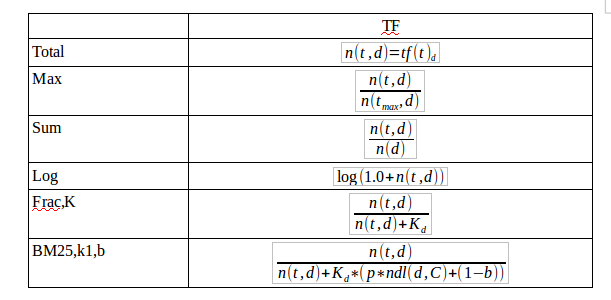

Pour Total : 

In [18]:
le = lex.getLexiconEntry( "franc" )
wmodel = pt.autoclass("org.terrier.matching.models.Tf")()
wmodel.setCollectionStatistics(index.getCollectionStatistics())
wmodel.setEntryStatistics(le);
wmodel.setKeyFrequency(1) 
wmodel.prepare()

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),meta.getItem("url", posting.getId()),meta.getItem("title", posting.getId()),wmodel.score(posting)) for posting in inv.getPostings(le)], key=lambda e:e[3]):
  print("%s %s %s with score %0.4f"  % (docno, url, title, score))

3644 https://simple.wikipedia.org/wiki/Madeleine_of_France Wikipedia: Madeleine of France with score 4.0000
5985 https://simple.wikipedia.org/wiki/R%C3%A9union Wikipedia: Réunion with score 4.0000
150535 https://simple.wikipedia.org/wiki/Nessma Wikipedia: Nessma with score 4.0000
3639 https://simple.wikipedia.org/wiki/Claude_of_France Wikipedia: Claude of France with score 3.0000
3642 https://simple.wikipedia.org/wiki/Henry_II_of_France Wikipedia: Henry II of France with score 3.0000
14110 https://simple.wikipedia.org/wiki/Melun Wikipedia: Melun with score 3.0000
21527 https://simple.wikipedia.org/wiki/Prime_Minister_of_France Wikipedia: Prime Minister of France with score 3.0000
24301 https://simple.wikipedia.org/wiki/Treaty_of_Troyes Wikipedia: Treaty of Troyes with score 3.0000
35438 https://simple.wikipedia.org/wiki/Metropolitan_France Wikipedia: Metropolitan France with score 3.0000
35495 https://simple.wikipedia.org/wiki/CFP_Franc Wikipedia: CFP Franc with score 3.0000


Pour le log : 

In [19]:
import math 

for docno, url, title, score in nlargest(10, [(meta.getItem("docno", posting.getId()),meta.getItem("url", posting.getId()),meta.getItem("title", posting.getId()),math.log(1 + wmodel.score(posting))) for posting in inv.getPostings(le)], key=lambda e:e[3]):
  print("%s %s %s with score %0.4f"  % (docno, url, title, score))

3644 https://simple.wikipedia.org/wiki/Madeleine_of_France Wikipedia: Madeleine of France with score 1.6094
5985 https://simple.wikipedia.org/wiki/R%C3%A9union Wikipedia: Réunion with score 1.6094
150535 https://simple.wikipedia.org/wiki/Nessma Wikipedia: Nessma with score 1.6094
3639 https://simple.wikipedia.org/wiki/Claude_of_France Wikipedia: Claude of France with score 1.3863
3642 https://simple.wikipedia.org/wiki/Henry_II_of_France Wikipedia: Henry II of France with score 1.3863
14110 https://simple.wikipedia.org/wiki/Melun Wikipedia: Melun with score 1.3863
21527 https://simple.wikipedia.org/wiki/Prime_Minister_of_France Wikipedia: Prime Minister of France with score 1.3863
24301 https://simple.wikipedia.org/wiki/Treaty_of_Troyes Wikipedia: Treaty of Troyes with score 1.3863
35438 https://simple.wikipedia.org/wiki/Metropolitan_France Wikipedia: Metropolitan France with score 1.3863
35495 https://simple.wikipedia.org/wiki/CFP_Franc Wikipedia: CFP Franc with score 1.3863


et le choix pour le df

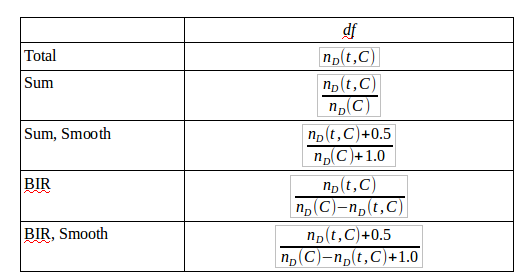

pour rappel, le IDF est égale au $-log(df)$

## 6. Évaluation manuelle
Utilisez plusieurs des méthodes des points précédents avec la requête ***france***. Identifiez les différences parmi toutes les méthodes que vous avez implémentée. Avec les premiers 5 résultats pouvez vous dire quelle méthode vous semble la plus pertinente ? Pourquoi ?

## 7. Le titre
Effectuez une requête par titre et puis par contenue des pages Wikipédia. Trouvez vous de différences ? Les méthodes sont-ils plus ou moins pertinents selon le champ utilisé ? Pourquoi ?